# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

KeyboardInterrupt: 

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

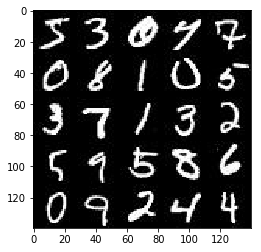

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

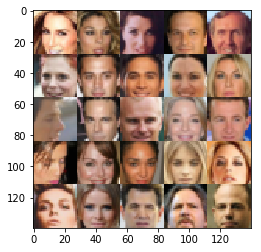

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    dropout = 0.7
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28*28*3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, dropout)
        # 14*14*64 now
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, dropout)
        # 7*7*128 now
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, dropout)
        # 4*4*256 now

        # Flatten it
        flat = tf.reshape(x2, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7*7*256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7*7*128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14*14*64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28*28*out_channel_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3]) 
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    out_channel_dim = 3 if data_image_mode=="RGB" else 1
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Batch images for discriminator
                batch_images = batch_images * 2
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z,
                                               lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, 
                                                input_real:batch_images,
                                                lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6103... Generator Loss: 0.5852
Epoch 1/2... Discriminator Loss: 1.5979... Generator Loss: 0.6447
Epoch 1/2... Discriminator Loss: 1.5240... Generator Loss: 0.6354
Epoch 1/2... Discriminator Loss: 1.3415... Generator Loss: 0.6825
Epoch 1/2... Discriminator Loss: 1.4403... Generator Loss: 0.6465
Epoch 1/2... Discriminator Loss: 1.4340... Generator Loss: 0.6634
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.7222
Epoch 1/2... Discriminator Loss: 1.4855... Generator Loss: 0.7130
Epoch 1/2... Discriminator Loss: 1.3829... Generator Loss: 0.6824
Epoch 1/2... Discriminator Loss: 1.3850... Generator Loss: 0.6981


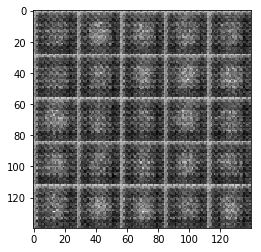

Epoch 1/2... Discriminator Loss: 1.4327... Generator Loss: 0.7463
Epoch 1/2... Discriminator Loss: 1.3572... Generator Loss: 0.7658
Epoch 1/2... Discriminator Loss: 1.3279... Generator Loss: 0.7954
Epoch 1/2... Discriminator Loss: 1.2310... Generator Loss: 0.7878
Epoch 1/2... Discriminator Loss: 1.2946... Generator Loss: 0.7704
Epoch 1/2... Discriminator Loss: 1.1801... Generator Loss: 0.9425
Epoch 1/2... Discriminator Loss: 1.2506... Generator Loss: 0.8585
Epoch 1/2... Discriminator Loss: 1.2535... Generator Loss: 0.8919
Epoch 1/2... Discriminator Loss: 1.2195... Generator Loss: 0.8375
Epoch 1/2... Discriminator Loss: 1.2645... Generator Loss: 0.8303


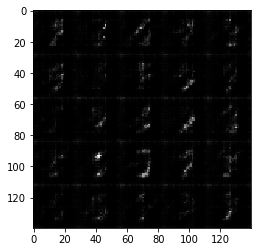

Epoch 1/2... Discriminator Loss: 1.2470... Generator Loss: 0.8130
Epoch 1/2... Discriminator Loss: 1.3119... Generator Loss: 0.8268
Epoch 1/2... Discriminator Loss: 1.2706... Generator Loss: 0.8432
Epoch 1/2... Discriminator Loss: 1.2717... Generator Loss: 0.8583
Epoch 1/2... Discriminator Loss: 1.2395... Generator Loss: 0.8308
Epoch 1/2... Discriminator Loss: 1.3095... Generator Loss: 0.8063
Epoch 1/2... Discriminator Loss: 1.2060... Generator Loss: 0.8797
Epoch 1/2... Discriminator Loss: 1.3847... Generator Loss: 0.7739
Epoch 1/2... Discriminator Loss: 1.3133... Generator Loss: 0.8009
Epoch 1/2... Discriminator Loss: 1.3792... Generator Loss: 0.8274


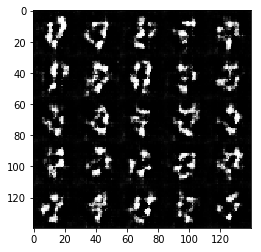

Epoch 1/2... Discriminator Loss: 1.3000... Generator Loss: 0.8259
Epoch 1/2... Discriminator Loss: 1.3508... Generator Loss: 0.7778
Epoch 1/2... Discriminator Loss: 1.3404... Generator Loss: 0.7941
Epoch 1/2... Discriminator Loss: 1.3251... Generator Loss: 0.8106
Epoch 1/2... Discriminator Loss: 1.2897... Generator Loss: 0.8441
Epoch 1/2... Discriminator Loss: 1.2579... Generator Loss: 0.7788
Epoch 1/2... Discriminator Loss: 1.3298... Generator Loss: 0.8078
Epoch 1/2... Discriminator Loss: 1.3333... Generator Loss: 0.8162
Epoch 1/2... Discriminator Loss: 1.3201... Generator Loss: 0.7986
Epoch 1/2... Discriminator Loss: 1.3136... Generator Loss: 0.7975


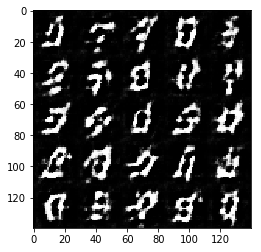

Epoch 1/2... Discriminator Loss: 1.2771... Generator Loss: 0.7969
Epoch 1/2... Discriminator Loss: 1.3322... Generator Loss: 0.8378
Epoch 1/2... Discriminator Loss: 1.3205... Generator Loss: 0.7608
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 0.8029
Epoch 1/2... Discriminator Loss: 1.3232... Generator Loss: 0.7715
Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 0.8323
Epoch 2/2... Discriminator Loss: 1.3443... Generator Loss: 0.8040
Epoch 2/2... Discriminator Loss: 1.2700... Generator Loss: 0.8182
Epoch 2/2... Discriminator Loss: 1.3567... Generator Loss: 0.7983
Epoch 2/2... Discriminator Loss: 1.3046... Generator Loss: 0.7729


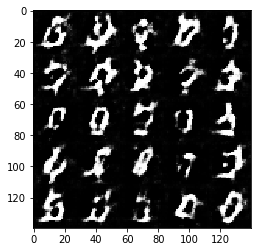

Epoch 2/2... Discriminator Loss: 1.2576... Generator Loss: 0.8120
Epoch 2/2... Discriminator Loss: 1.3530... Generator Loss: 0.7771
Epoch 2/2... Discriminator Loss: 1.2921... Generator Loss: 0.7981
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.8023
Epoch 2/2... Discriminator Loss: 1.3339... Generator Loss: 0.7539
Epoch 2/2... Discriminator Loss: 1.3341... Generator Loss: 0.8131
Epoch 2/2... Discriminator Loss: 1.3084... Generator Loss: 0.8244
Epoch 2/2... Discriminator Loss: 1.3567... Generator Loss: 0.7556
Epoch 2/2... Discriminator Loss: 1.3199... Generator Loss: 0.7704
Epoch 2/2... Discriminator Loss: 1.3188... Generator Loss: 0.8402


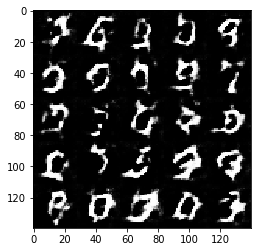

Epoch 2/2... Discriminator Loss: 1.3380... Generator Loss: 0.7814
Epoch 2/2... Discriminator Loss: 1.2526... Generator Loss: 0.8086
Epoch 2/2... Discriminator Loss: 1.3395... Generator Loss: 0.7430
Epoch 2/2... Discriminator Loss: 1.3010... Generator Loss: 0.7999
Epoch 2/2... Discriminator Loss: 1.2809... Generator Loss: 0.7779
Epoch 2/2... Discriminator Loss: 1.3266... Generator Loss: 0.7211
Epoch 2/2... Discriminator Loss: 1.3353... Generator Loss: 0.7447
Epoch 2/2... Discriminator Loss: 1.3281... Generator Loss: 0.8075
Epoch 2/2... Discriminator Loss: 1.2963... Generator Loss: 0.8320
Epoch 2/2... Discriminator Loss: 1.3647... Generator Loss: 0.7820


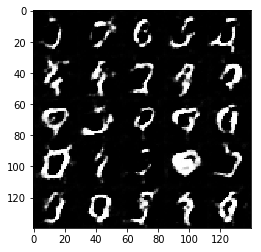

Epoch 2/2... Discriminator Loss: 1.3747... Generator Loss: 0.7542
Epoch 2/2... Discriminator Loss: 1.2851... Generator Loss: 0.7761
Epoch 2/2... Discriminator Loss: 1.3077... Generator Loss: 0.7422
Epoch 2/2... Discriminator Loss: 1.3119... Generator Loss: 0.7949
Epoch 2/2... Discriminator Loss: 1.3429... Generator Loss: 0.7566
Epoch 2/2... Discriminator Loss: 1.2793... Generator Loss: 0.8274
Epoch 2/2... Discriminator Loss: 1.2967... Generator Loss: 0.7706
Epoch 2/2... Discriminator Loss: 1.2919... Generator Loss: 0.7631
Epoch 2/2... Discriminator Loss: 1.3110... Generator Loss: 0.7678
Epoch 2/2... Discriminator Loss: 1.3177... Generator Loss: 0.8271


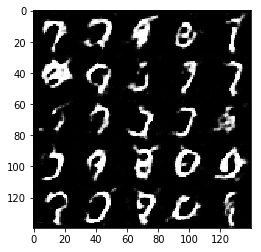

Epoch 2/2... Discriminator Loss: 1.2405... Generator Loss: 0.7937
Epoch 2/2... Discriminator Loss: 1.3247... Generator Loss: 0.8451
Epoch 2/2... Discriminator Loss: 1.3211... Generator Loss: 0.7970
Epoch 2/2... Discriminator Loss: 1.2799... Generator Loss: 0.8422
Epoch 2/2... Discriminator Loss: 1.3511... Generator Loss: 0.8319
Epoch 2/2... Discriminator Loss: 1.3266... Generator Loss: 0.7826
Epoch 2/2... Discriminator Loss: 1.2485... Generator Loss: 0.7878
Epoch 2/2... Discriminator Loss: 1.3302... Generator Loss: 0.7690
Epoch 2/2... Discriminator Loss: 1.2986... Generator Loss: 0.7539
Epoch 2/2... Discriminator Loss: 1.2719... Generator Loss: 0.8211


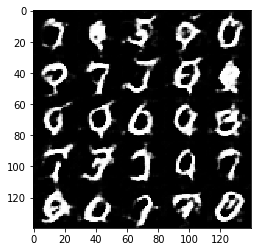

Epoch 2/2... Discriminator Loss: 1.2912... Generator Loss: 0.8410
Epoch 2/2... Discriminator Loss: 1.3640... Generator Loss: 0.7270
Epoch 2/2... Discriminator Loss: 1.3222... Generator Loss: 0.7818


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7548... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.7770... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.6334... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.6535... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.6562... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.5976... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.5215... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.7538


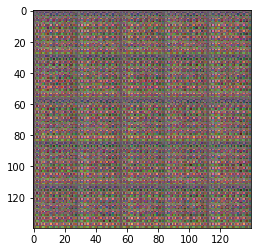

Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.9406
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 0.9973... Generator Loss: 1.0456


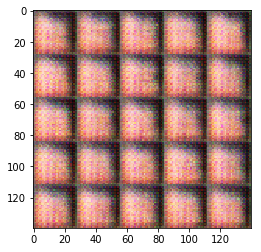

Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 0.9335
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 0.9474... Generator Loss: 0.9815
Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 1.0368
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 1.0149
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 0.8941... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 0.8846... Generator Loss: 0.9782


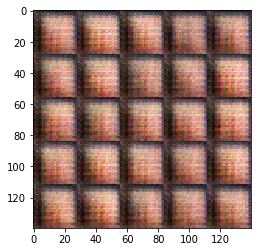

Epoch 1/1... Discriminator Loss: 0.7857... Generator Loss: 1.0623
Epoch 1/1... Discriminator Loss: 0.7381... Generator Loss: 1.0948
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 1.2051
Epoch 1/1... Discriminator Loss: 0.6886... Generator Loss: 1.1339
Epoch 1/1... Discriminator Loss: 0.7660... Generator Loss: 1.2538
Epoch 1/1... Discriminator Loss: 0.6662... Generator Loss: 1.2583
Epoch 1/1... Discriminator Loss: 0.7318... Generator Loss: 1.2159
Epoch 1/1... Discriminator Loss: 0.6360... Generator Loss: 1.3590
Epoch 1/1... Discriminator Loss: 0.7022... Generator Loss: 1.2712
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.2735


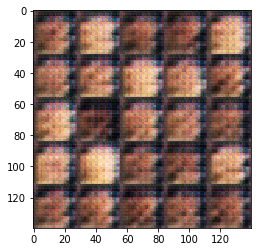

Epoch 1/1... Discriminator Loss: 0.7778... Generator Loss: 1.2283
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.2056
Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 1.2789
Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 1.2523
Epoch 1/1... Discriminator Loss: 0.7014... Generator Loss: 1.1826
Epoch 1/1... Discriminator Loss: 0.7121... Generator Loss: 1.2340
Epoch 1/1... Discriminator Loss: 0.6897... Generator Loss: 1.2491
Epoch 1/1... Discriminator Loss: 0.7886... Generator Loss: 1.1597
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 1.3479
Epoch 1/1... Discriminator Loss: 0.6722... Generator Loss: 1.4337


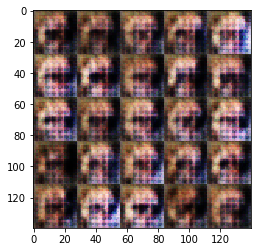

Epoch 1/1... Discriminator Loss: 0.7623... Generator Loss: 1.1960
Epoch 1/1... Discriminator Loss: 0.7628... Generator Loss: 1.2553
Epoch 1/1... Discriminator Loss: 0.8594... Generator Loss: 1.1174
Epoch 1/1... Discriminator Loss: 0.7020... Generator Loss: 1.5220
Epoch 1/1... Discriminator Loss: 0.7143... Generator Loss: 1.3054
Epoch 1/1... Discriminator Loss: 0.7444... Generator Loss: 1.2444
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 1.2174
Epoch 1/1... Discriminator Loss: 0.7004... Generator Loss: 1.5796
Epoch 1/1... Discriminator Loss: 0.6547... Generator Loss: 1.4668
Epoch 1/1... Discriminator Loss: 0.6409... Generator Loss: 1.4315


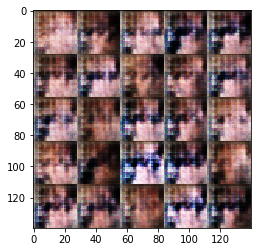

Epoch 1/1... Discriminator Loss: 0.6608... Generator Loss: 1.4900
Epoch 1/1... Discriminator Loss: 0.6297... Generator Loss: 1.4527
Epoch 1/1... Discriminator Loss: 0.5485... Generator Loss: 1.4922
Epoch 1/1... Discriminator Loss: 0.5327... Generator Loss: 1.6859
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.3654
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 1.0649
Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.2944
Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 0.7845... Generator Loss: 1.3363


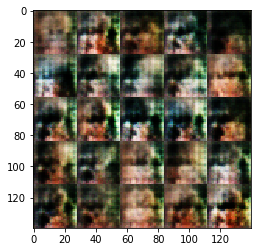

Epoch 1/1... Discriminator Loss: 0.7055... Generator Loss: 1.5158
Epoch 1/1... Discriminator Loss: 0.7881... Generator Loss: 1.3066
Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 0.9649
Epoch 1/1... Discriminator Loss: 0.7919... Generator Loss: 1.2953
Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 1.3327
Epoch 1/1... Discriminator Loss: 0.7424... Generator Loss: 1.4339
Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 1.4006
Epoch 1/1... Discriminator Loss: 0.7514... Generator Loss: 1.2637
Epoch 1/1... Discriminator Loss: 0.6062... Generator Loss: 1.5096
Epoch 1/1... Discriminator Loss: 0.7347... Generator Loss: 1.3927


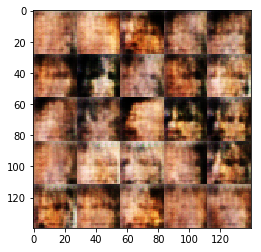

Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 1.1152
Epoch 1/1... Discriminator Loss: 0.7988... Generator Loss: 1.1814
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 1.4775
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 0.8967... Generator Loss: 1.0123
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 1.0880
Epoch 1/1... Discriminator Loss: 0.7672... Generator Loss: 1.2433
Epoch 1/1... Discriminator Loss: 0.7994... Generator Loss: 1.2374
Epoch 1/1... Discriminator Loss: 0.8278... Generator Loss: 1.1116


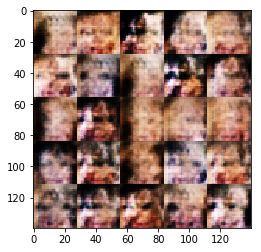

Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 1.1609
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 1.3581
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 1.3307
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 1.1541
Epoch 1/1... Discriminator Loss: 0.8457... Generator Loss: 1.3440
Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 1.2161
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 1.1626
Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 1.2464
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 1.0705


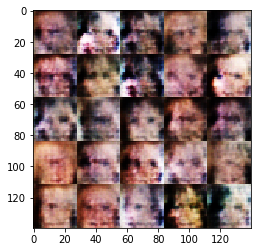

Epoch 1/1... Discriminator Loss: 0.8155... Generator Loss: 1.1899
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 1.2629
Epoch 1/1... Discriminator Loss: 0.8736... Generator Loss: 1.1666
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 1.0442
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.4157
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 2.0968... Generator Loss: 1.5598
Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 1.1452
Epoch 1/1... Discriminator Loss: 0.8128... Generator Loss: 1.2160
Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 1.0728


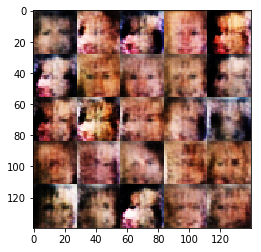

Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 1.1305
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 1.1636
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 1.0938
Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 1.1761
Epoch 1/1... Discriminator Loss: 0.7193... Generator Loss: 1.4139
Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 1.5005
Epoch 1/1... Discriminator Loss: 0.9247... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 0.8746... Generator Loss: 1.1906
Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 1.3144


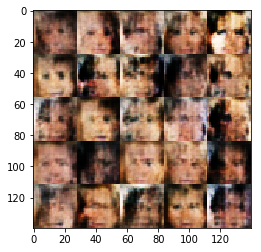

Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 1.3779
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 1.1111
Epoch 1/1... Discriminator Loss: 0.8484... Generator Loss: 1.3034
Epoch 1/1... Discriminator Loss: 0.9014... Generator Loss: 1.1953
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 1.3560
Epoch 1/1... Discriminator Loss: 0.6826... Generator Loss: 1.7327
Epoch 1/1... Discriminator Loss: 0.7402... Generator Loss: 1.4665
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 0.8239


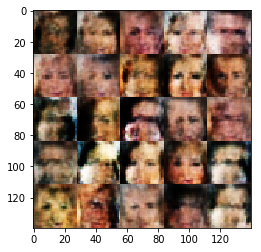

Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 0.9893
Epoch 1/1... Discriminator Loss: 0.8168... Generator Loss: 1.2725
Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 0.7087... Generator Loss: 1.5595
Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 1.1606
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 1.2413
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.2541
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.0979
Epoch 1/1... Discriminator Loss: 0.7617... Generator Loss: 1.5288


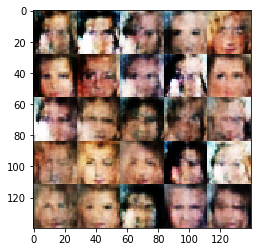

Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 1.0636
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.0103
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 1.5178
Epoch 1/1... Discriminator Loss: 0.8916... Generator Loss: 1.1739
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 0.6442... Generator Loss: 1.7181
Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 1.1423
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 1.0926
Epoch 1/1... Discriminator Loss: 6.2745... Generator Loss: 0.3794


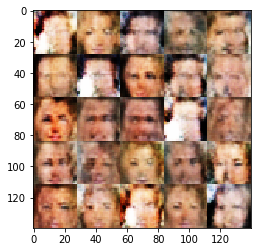

Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 1.3871
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 1.1539
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 1.2141
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 1.3075


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.